In [53]:
import stan
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import json
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# work around to get stan working in a notebook
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [2]:
# df = pd.read_csv('final_voting_data_long.csv')
df = pd.read_csv('eurovision_merged_covariates_03Feb.csv').drop('Unnamed: 0', axis=1)
df['has_border'] = df['has_border'].replace(np.nan,0)
df.head()

,Year,From country,Votes,Country,Own,English,Other,has_border,migration_band,migration_year,code,code3,population,count,prop_emigrants,Gender,comps_since_last_win
0,1999,AT,12.0,Bosnia and Herzegovina,0.0,0.0,1.0,0.0,2000,2000,BA,BIH,4179350.0,273,0.000065,group,43
1,1999,AT,0.0,Belgium,0.0,1.0,0.0,0.0,2000,2000,BE,BEL,10251250.0,2486,0.000243,female,12
2,1999,AT,0.0,Cyprus,1.0,0.0,0.0,0.0,2000,2000,CY,CYP,948237.0,161,0.000170,female,43
3,1999,AT,10.0,Germany,0.0,0.0,1.0,1.0,2000,2000,DE,DEU,82211508.0,181487,0.002208,group,16
4,1999,AT,5.0,Denmark,0.0,1.0,0.0,0.0,2000,2000,DK,DNK,5339616.0,1525,0.000286,group,35


In [3]:
def format_votes(x):
  if x == 12.:
    return 10
  elif x == 10.:
    return 9
  return int(x)
print(set(df['Votes']))
df['indexed_votes'] = df['Votes'].apply(format_votes)
score_options = df['indexed_votes'].unique().tolist()
score_options.sort()
print(score_options)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10.0, 12.0}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [4]:
# Given gender is a categoric variable with 3 classes, encode as binary w.r.t default gender='group'
df['male'] = [1 if gender=='male' else 0 for gender in df['Gender']]
df['female'] = [1 if gender=='female' else 0 for gender in df['Gender']]

In [39]:
model = """
data {
  int<lower=2> S;
  int<lower=0> N;
  int<lower=1> D;
  array[N] int<lower=0, upper=S> y;
  array[N] row_vector[D] x;

  int<lower=0> N_new; // number of predictions
  array[N_new] row_vector[D] x_new; // covariates for predictions
}
parameters {
  vector[D] beta;
  ordered[S-1] lambda;
}
model {
  beta ~ normal(0, 10000);
  lambda ~ normal(0, 3.2);

  for (n in 1:N) {
    if (y[n] == 0) {
      1 ~ bernoulli_logit(x[n] * beta);
    } else {
      0 ~ bernoulli_logit(x[n] * beta);
      y[n] ~ ordered_logistic(x[n] * beta, lambda);
    }
  }
}
generated quantities {
  vector[N] y_hat;
  for (n in 1:N) {
    if (bernoulli_logit_rng(x[n] * beta) == 0) {
      y_hat[n] = 0;
    } else {
      y_hat[n] = ordered_logistic_rng(x[n] * beta, lambda);
    }
  }

  // out of sample predictions (scores we expect to observe for new data)
  vector[N_new] y_pred;
  for (n in 1:N_new) {
    if (bernoulli_logit_rng(x_new[n] * beta) == 0) {
      y_pred[n] = 0;
    } else {
      y_pred[n] = ordered_logistic_rng(x_new[n] * beta, lambda);
    }
  } 
}
"""

In [25]:
# test simple poisson hurdel model
# model = '''
# data {
#   int<lower=0> N;
#   int<lower=0, upper=10> y[N];
# }
# parameters {
#   real<lower=0, upper=1> theta;
#   real<lower=0> lambda;
# }
# model {
#   for (n in 1:N) {
#     if (y[n] == 0)
#       1 ~ bernoulli(theta);
#     else {
#       0 ~ bernoulli(theta);
#       y[n] ~ poisson(lambda) T[1, ];
#     }
#   }
  
# }
# '''

In [6]:
# test/train split
train_fraction = 0.8
n_train = math.floor(train_fraction * df.shape[0])

In [7]:
# build x matrix
x = df.loc[:,['Own','Other','male','female','has_border','prop_emigrants','comps_since_last_win']].values
x_test = x[n_train:]
x = x[:n_train]
print(x.shape)

(12361, 7)


In [8]:
# asses distribution of features (all features are binary with the exceptions of 'prop_emigrants' and 'comps_since_last_win')
def plt_discrete_feats(x):
    pltL = plt.subplot(1,2,1); pltR = plt.subplot(1,2,2)
    pltL.hist(x[:,5],bins=100)
    pltL.set_title('prop_emigrants')

    pltR.hist(x[:,6],bins=100)
    pltR.set_title('comps_since_last_win')

In [40]:
# try log transform followed by standardisation on 'prop_emigrants'
prop = x[:,5]
prop_sort = np.sort(prop)
print(f'smallest non-zero value: {prop_sort[prop_sort != 0][0]}')
x_prop_log = np.log10(prop + 4e-08)   # rule of thumb, half of smallest non-zero value
prop_std_scaler = StandardScaler()
x_prop_log_std = prop_std_scaler.fit_transform(x_prop_log.reshape(-1, 1))

# transform x_test using transformation fit on x
x_test_prop_log = np.log10(x_test[:,5] + 4e-08)
x_test_prop_log_std = prop_std_scaler.transform(x_test_prop_log.reshape(-1, 1))

smallest non-zero value: 8.911476114280948e-08


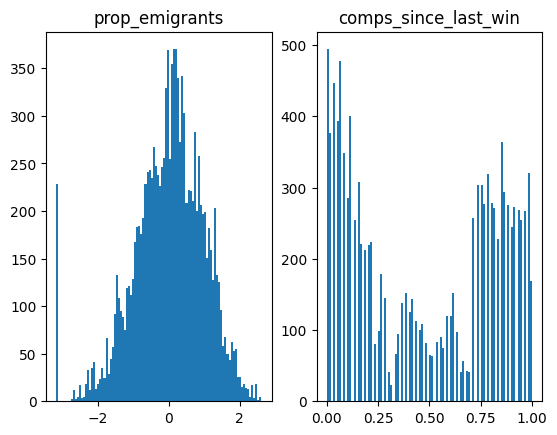

In [41]:
# minmax scaling of 'comps_since_last_win'and log-std scaling of 'prop_emigrants'
scaler = MinMaxScaler() 
x_norm = scaler.fit_transform(x)
x_norm[:,5] = x_prop_log_std[:,0]
plt_discrete_feats(x_norm)

# scale x_test with scaler fit on x
x_test_norm = scaler.transform(x_test)
x_test_norm[:,5] = x_test_prop_log_std[:,0]

In [42]:
data = {
    'S': 10,  # changed from 11 -> 10 (because ordinal regression now only models votes 1,2,3,4,5,6,7,8,10,12. 
                # The logistic regression models the 0 vote)
    'N': n_train,
    'D': x_norm.shape[1],
    'y': df['indexed_votes'][:n_train].values,
    'x': x_norm,
    'N_new': df.shape[0]-n_train,
    'x_new': x_test_norm
}

In [55]:
# write y_test to file for later analysis
with open('model_output/y_test_model_2_hurdle_2500_samples_4_chains.json', 'w') as f:
    json.dump(df['indexed_votes'][n_train:].values.tolist(),f)

In [14]:
# data for simple poisson hurdle model baseline
# data = {
#     'N': n_train,
#     'y': df['indexed_votes'][:n_train].values,
# }

In [46]:
posterior = stan.build(model, data=data)
fit = posterior.sample(num_chains=4, num_warmup=1000, num_samples=2500)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/82/6xch38_95_d545t14cp867pc0000gr/T/httpstan_c8i0h44a/model_olxrdvvr.stan', line 17, column 19: Argument
    10000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/14000)
Sampling:   0% (2/14000)
Sampling:   0% (3/14000)
Sampling:   0% (4/14000)
Sampling:   1% (103/14000)
Sampling:   1% (202/14000)
Sampling:   2% (301/14000)
Sampling:   3% (400/14000)
Sampling:   4% (500/14000)
Sampling:   4% (600/14000)
Sampling:   5% (700/14000)
Sampling:   6% (800/14000)
Sampling:   6% (900/14000)
Sampling:   7% (1000/14000)
Sampling:   8% (1100/14000)
Sampling:   9% (1200/14000)
Sampling:   9% (1300/14000)
Sampling:  10% (1400/14000)
Sampling:  11% (1500/14000)
Sampling:  11% (1600/14000)
Sampling:  12% (1700/14000)
Sampling:  13% (1800/14000)
Sampling:  14% (1900/14000)
Sampling:  14% (2000/14000)
Sampling:  15%

In [47]:
az_fit = az.from_pystan(
    posterior=fit, 
    observed_data="y", 
    posterior_predictive="y_hat",
    predictions="y_pred", 
    posterior_model=posterior)

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n4'}>],
       [<Axes: title={'center': 'beta\n5'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n6'}>]], dtype=object)

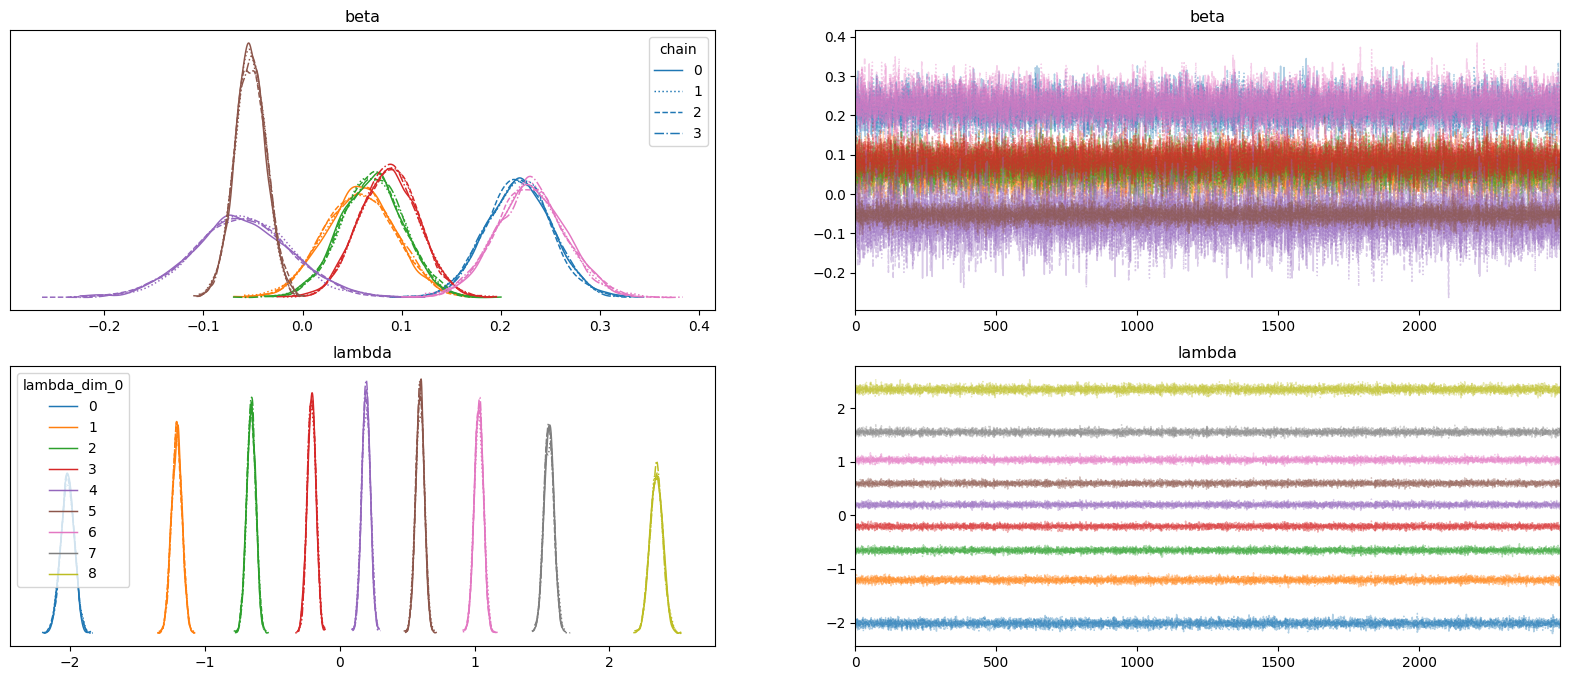

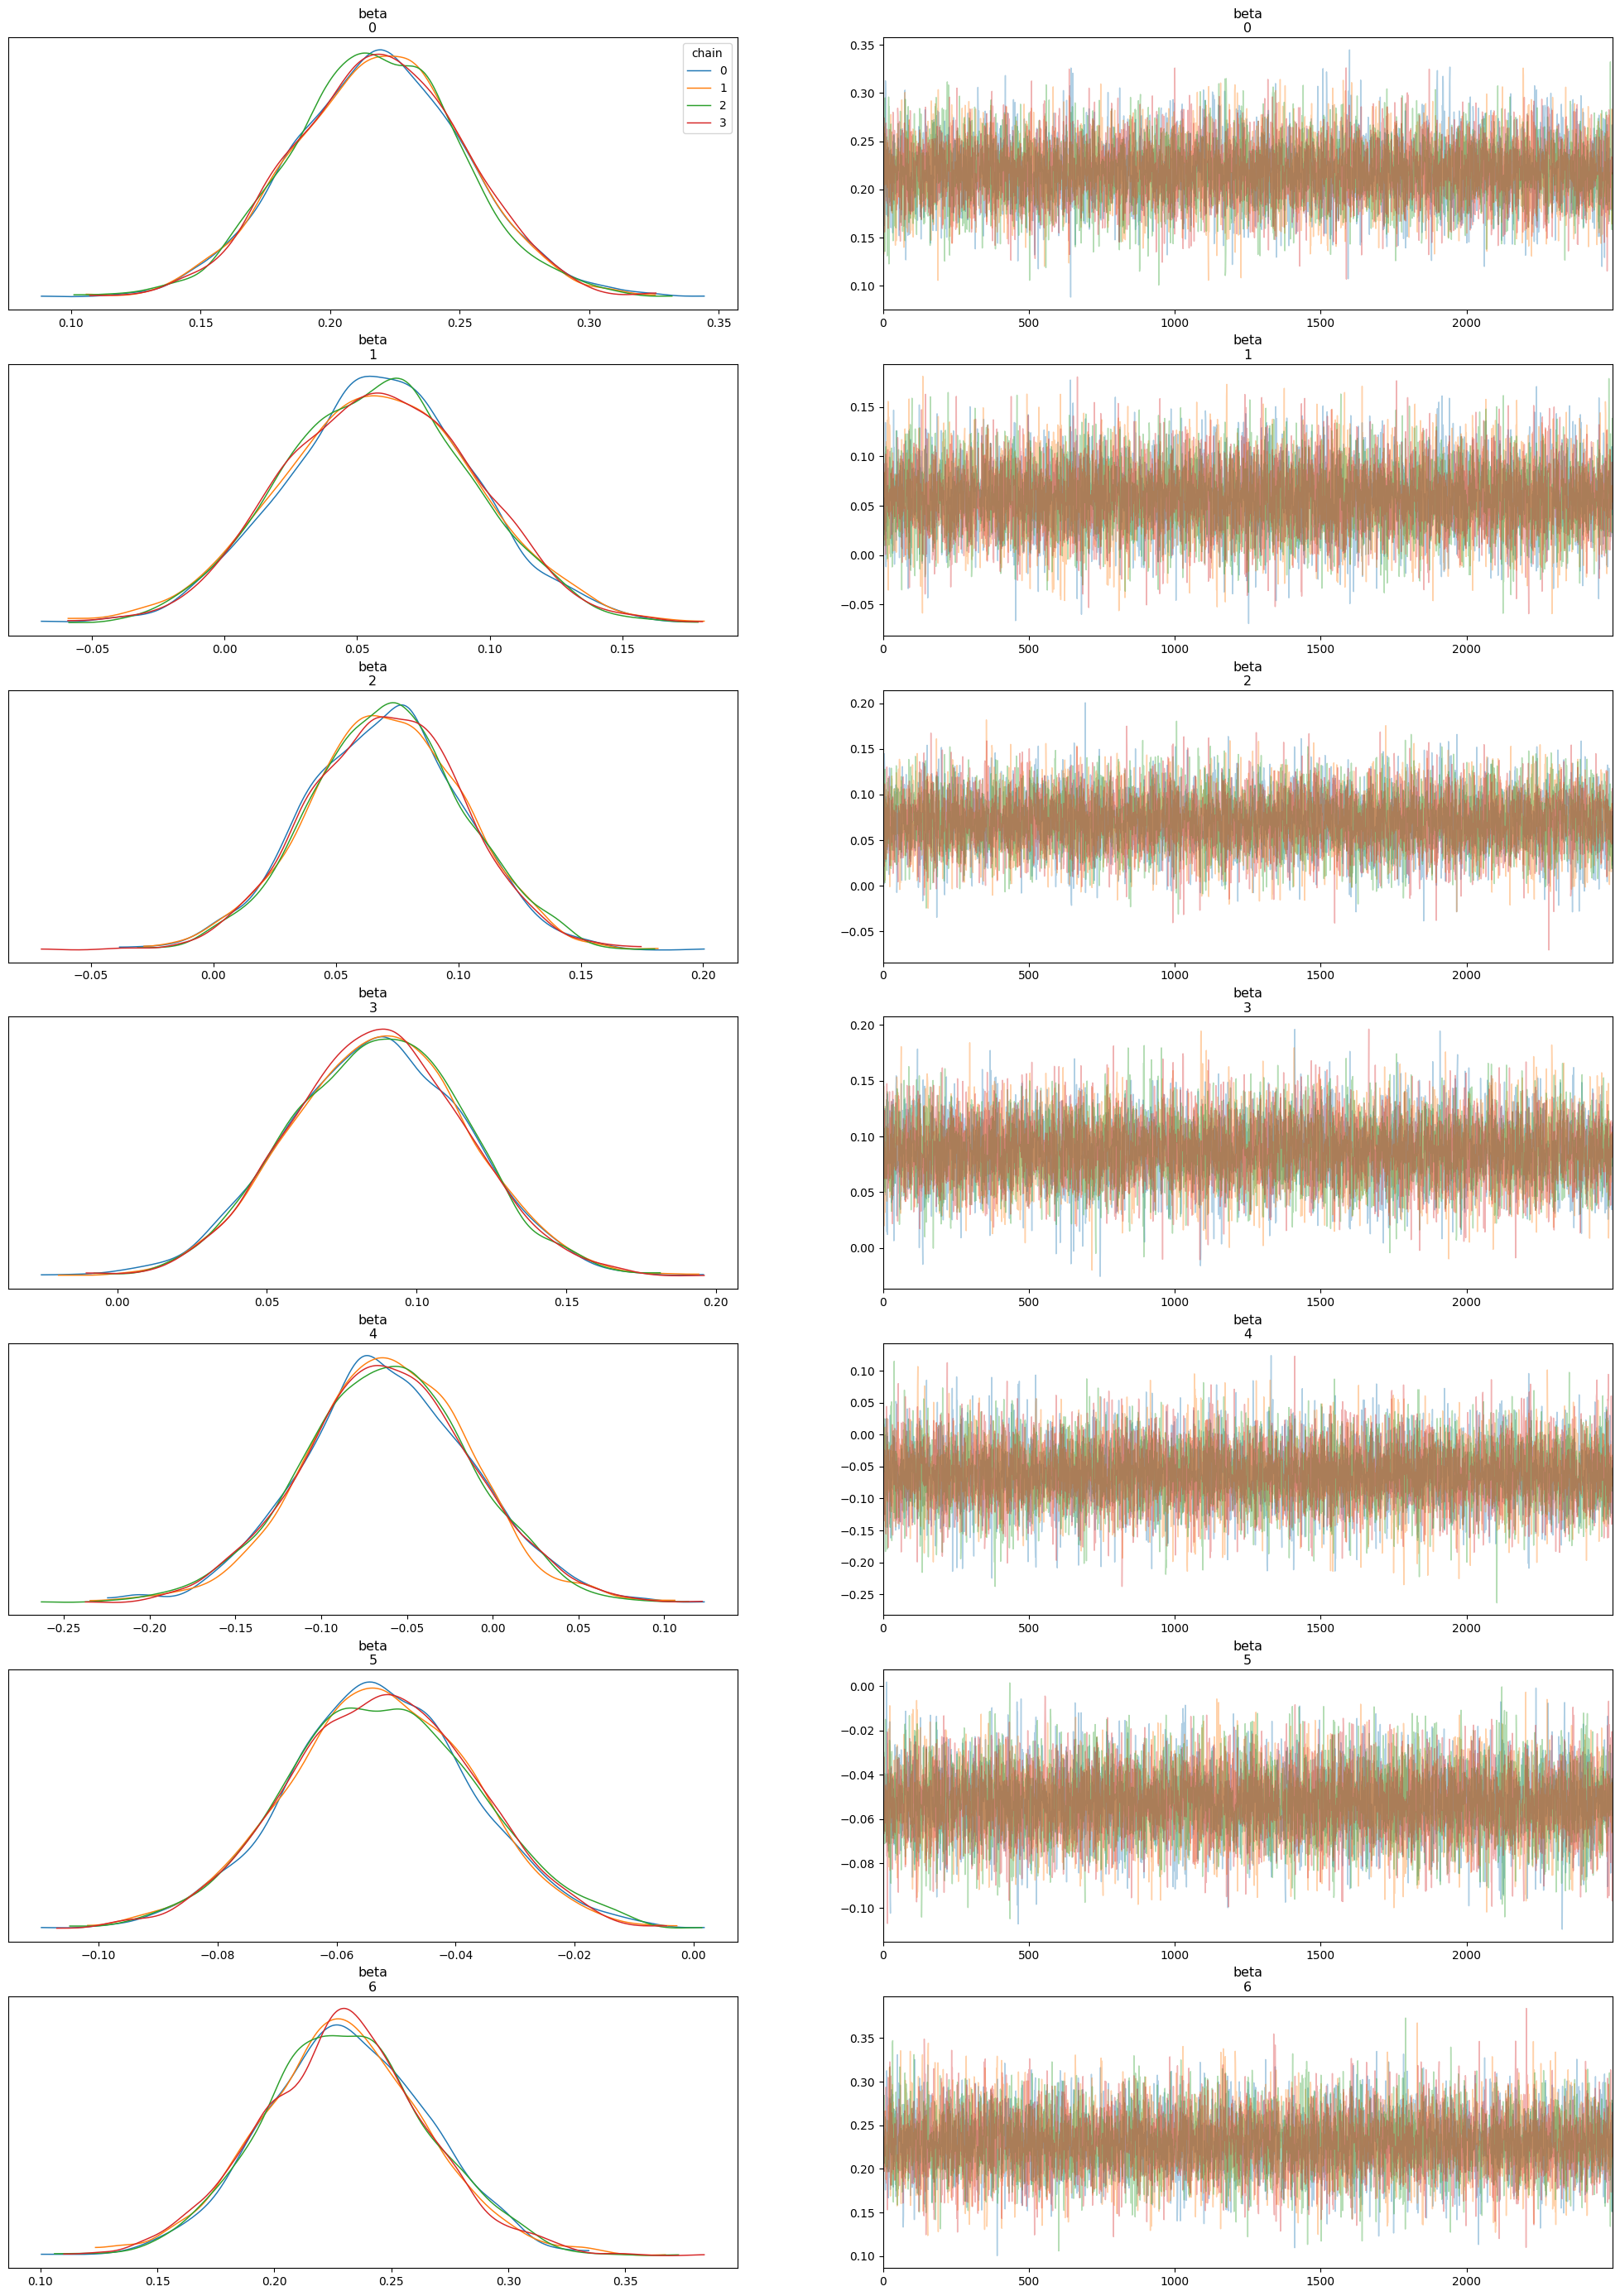

In [48]:
az.plot_trace(az_fit, ["beta","lambda"], figsize=(20,8), legend=True)
az.plot_trace(az_fit, ["beta"], figsize=(25,35), legend=True, compact=False)

In [49]:
az_fit.to_json("model_output/model_2_hurdle_2500_samples_4_chains.json")

'model_2_hurdle_2500_samples_4_chains.json'

In [ ]:
with open('model_output/y_pred_model_2_hurdle_2500_samples_4_chains.json', 'w') as f:
    json.dump(az_fit.predictions.y_pred.tolist(),f)